In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip3 install cython
!pip3 install tables
!pip3 install statsmodels
!pip3 install -q keras
!pip3 install gensim
!pip3 install nltk

In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import tensorflow as tf

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model, load_model
from keras.layers import Input, CuDNNLSTM, Activation, Lambda, Dense, LeakyReLU, Conv1D,GlobalAveragePooling1D
from keras.layers import Dropout, Bidirectional,Concatenate, BatchNormalization, Flatten
from keras import backend as K, regularizers
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.constraints import maxnorm
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
ratio = 6
data_dir = 'drive/My Drive/'
data_file = 'drive/My Drive/5minNo_normalized_data.h5'

num_prev_values = 12
start = [30]
num_classes = 10
cutoff = []
# data_dir = 'drive/My Drive/btp/sem2_start/Prediction/'
# data_file = 'drive/My Drive/btp/sem2_start/Prediction/No_normalized_data.h5'

In [0]:
df = pd.read_hdf(data_file)

In [0]:
df.head()

,claim,num_rev,avg_rat,actualdis,dealdis,timeRem,num_type,recordtime,fixedEffects,day,...,day*avg_rat,dealdis*actualdis,num_type*actualdis,day*actualdis,num_type*dealdis,day*dealdis,day*num_type,deal_id,asin,y
0,0.0,92.0,4.513926,28.387097,31.971326,28467046.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
1,0.0,92.0,4.513926,28.387097,31.971326,28153391.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
2,0.0,92.0,4.513926,28.387097,31.971326,27840476.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
3,0.0,92.0,4.513926,28.387097,31.971326,27516851.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
4,0.0,92.0,4.513926,28.387097,31.971326,27193850.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0


In [0]:
df.columns
df.shape

(4106495, 34)

In [0]:
def get_per_claim(df):

	claim = {}

	for index, row in df.iterrows():

		deal_id = row['deal_id']

		if(deal_id in claim):
			claim[deal_id].append(row[0])
		else:
			claim[deal_id] = [row[0]]

	return claim

In [0]:
def x_value(df, num_prev_values, start, claim):

	x = [[]]
	y = []
	x = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 9\
	 	# 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 \
	 	]].values

	y = df.iloc[:, [0]].values
	
	actual_x = [[]]
	actual_y = []

	for i in range(len(x)):

		perClaim = []
		asin = (df.iloc[[i]]['deal_id'].values)[0]
		perClaim = claim.get(asin)
		idx = perClaim.index(x[i][0])
		
		for j in range(len(start)):
		
			l = []
			if((idx - start[j] - num_prev_values + 1) < 0):
				continue

			l = (perClaim[(idx-start[j]-num_prev_values+1):(idx-start[j]+1)])

			for k in range(len(x[i]) - 1):
				l.append(x[i][k])

			l.append(start[j])
			actual_x.append(l)
			actual_y.append(y[i])

	actual_y = np.asarray(actual_y)
	
	return actual_x, actual_y

In [0]:
def y_value(y, num_classes, cutoff):

  if(len(cutoff) == 0):
    
    cutoff_pt = 100/num_classes
    num = int(num_classes/cutoff_pt)
    for i in range(0, num_classes):
      y[(y >= i*cutoff_pt) & (y < (i+1)*cutoff_pt)] = i    
    y[y == 100] = num_classes - 1

  else:
    
    y[y <= cutoff[0]] = 0
    for i in range(1, num_classes):
      y[(y > cutoff[i-1]) & (y <= cutoff[i])] = i

  return y

In [0]:
def equalSplit(x, y, ratio, num_classes):

  leny = []
  mini = np.count_nonzero(y==0)

  for i in range(num_classes):
    val = np.count_nonzero(y==i)
    leny.append(val)
    if(val != 0 and mini > val):
      mini = val

  y0 = y[np.where(y == 0), :][0]
  x0 = x[np.where(y == 0), :][0]
  index = np.random.choice(y0.shape[0], min(ratio*mini, leny[0]), replace = False)
  x0 = x0[index]
  y0 = y0[index]

  y1 = y[np.where(y == 1), :][0]
  x1 = x[np.where(y == 1), :][0]
  index = np.random.choice(y1.shape[0], min(ratio*mini, leny[1]), replace = False)
  x1 = x1[index]
  y1 = y1[index]

  actual_x = np.vstack((x0, x1))
  actual_y = np.vstack((y0, y1))

  for i in range(2, num_classes):

    y_prime = []
    x_prime = []
    y_prime = y[np.where(y == i), :][0]
    x_prime = x[np.where(y == i), :][0]

    if(leny[i] == 0):
      print(i)
      continue

    index = np.random.choice(y_prime.shape[0], min(ratio*mini, leny[i]), replace = False)

    x_prime = x_prime[index]
    y_prime = y_prime[index]
    actual_x = np.vstack((actual_x, x_prime))
    actual_y = np.vstack((actual_y, y_prime))

  return x, y

In [0]:
def StandardModel(numFeatures, Loss, optimizer):

	model = Sequential()
	model.add(Dense(12, input_dim = numFeatures, activation = 'relu'))
	model.add(Dense(8, activation = 'relu'))
	model.add(Dense(5, activation = 'softmax'))
	model.compile(loss = Loss, optimizer = optimizer, metrics = ['accuracy'])
	# model.fit(X, Y, epochs=150, batch_size=10,  verbose=2)
	# predictions = model.predict(X)

In [0]:
def define_model(num_classes):

	input = Input(shape = INPUT_SHAPE_1, dtype = 'float32', name = 'features')

	x = Dense(200, kernel_regularizer = regularizers.l2(1e-3) ,name = 'Fully_Connected_Layer_1')(input)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_1')(x)

	x = Dense(150, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_2')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_2')(x)

	x = Dense(90, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_3')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_3')(x)

	x = Dense(50, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_4')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_4')(x)

	output = Dense(num_classes, activation = 'softmax', name = 'Fully_Connected_Layer_5')(x)

	model = Model(inputs = [input], outputs = [output], name = 'my_model')

	return model

In [0]:
def define_model_2(num_classes):

  input = Input(shape = INPUT_SHAPE_1, dtype = 'float32', name = 'features')

  x = Dense(1024 ,name = 'Fully_Connected_Layer_0')(input)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)


  x = Dense(512 ,name = 'Fully_Connected_Layer_1')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_1')(x)

  x = Dense(256, name = 'Fully_Connected_Layer_2')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_2')(x)

  x = Dense(128, name = 'Fully_Connected_Layer_3')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_3')(x)

  x = Dense(64, name = 'Fully_Connected_Layer_4')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_4')(x)

  output = Dense(num_classes, activation = 'softmax', name = 'Fully_Connected_Layer_5')(x)

  model = Model(inputs = [input], outputs = [output], name = 'my_model')

  return model

In [0]:
def run_model(X_train, X_val, Y_train, Y_val, model):

	print(model.summary())
	model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])
	earlystop = EarlyStopping(monitor = 'val_loss', patience = PAT)
	check_pt = ModelCheckpoint(data_dir + 'model_.h5', save_best_only=True)
	callbacks_list = [earlystop, check_pt]

	trained_model = model.fit(X_train, [Y_train], epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, \
								validation_data = [X_val, [Y_val]], callbacks = callbacks_list)

	return trained_model, model

In [0]:
def run_model_2(X_train, X_val, Y_train, Y_val, model):

	print(model.summary())
	model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])
# 	earlystop = EarlyStopping(monitor = 'val_loss', patience = PAT)
# 	check_pt = ModelCheckpoint(data_dir + 'model_.h5', save_best_only=True)
# 	callbacks_list = [earlystop, check_pt]

	trained_model = model.fit(X_train, [Y_train], epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, \
								validation_data = [X_val, [Y_val]])

	return trained_model, model

In [0]:
def model_history(trained_model):

  fig, axs = plt.subplots(1,2,figsize=(15,5))

  axs[0].plot(trained_model.history['loss'])
  axs[0].plot(trained_model.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Validation'], loc='upper right')

  axs[1].plot(trained_model.history['acc'])
  axs[1].plot(trained_model.history['val_acc'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [0]:
claim = get_per_claim(df)
x, y = x_value(df, num_prev_values, start, claim)
store_y = y
x = x[1:]
x = np.asarray(x)
dfx = pd.DataFrame(x)
dfx.to_hdf(data_dir + '12_30_x_values.h5', key = 'dfx', mode = 'w')

In [0]:
print(len(x), len(y))
y = y_value(y, num_classes, cutoff)
dfy = pd.DataFrame(y)
dfy.to_hdf(data_dir + '12_30_y.h5', key = 'dfy', mode = 'w')
print('x and y created')
x, y = equalSplit(x, y, ratio, num_classes)
print('x and y equally splitted')

X_scaled = preprocessing.scale(x)
y = y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

# print(np.count_nonzero(y_train == 4))
# print(np.count_nonzero(y_train == 3))
# print(np.count_nonzero(y_train == 2))
# print(np.count_nonzero(y_train == 1))
# print(np.count_nonzero(y_train == 0))

y_train = np.squeeze(np.eye(num_classes)[y_train.reshape(-1)])
print(len(X_scaled), len(y))
y_val = np.squeeze(np.eye(num_classes)[y_val.reshape(-1)])
y_test = np.squeeze(np.eye(num_classes)[y_test.reshape(-1)])

1637685 1637685
x and y created
x and y equally splitted


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


1637685 1637685


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 20)                0         
_________________________________________________________________
Fully_Connected_Layer_0 (Den (None, 1024)              21504     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
Fully_Connected_Layer_1 (Den (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
Fully_Connected_Layer_2 (Den (None, 256)               131328    
_________________________________________________________________
leak

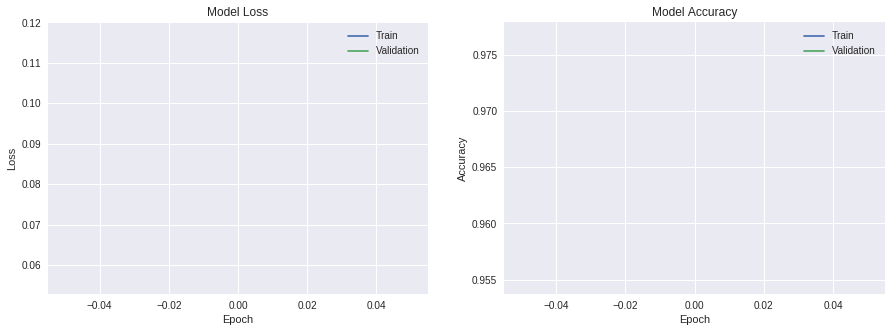

In [0]:
# print('Training started')
# clf = MLPClassifier()
# clf.fit(x_train, y_train)

# print('Testing Started')
# y_pred = clf.predict(x_train)
# print('Train Accuracy - ', accuracy_score(y_train, y_pred))
# y_pred = clf.predict(x_test)
# print('Test Accuracy - ', accuracy_score(y_test, y_pred))
# print(len(x_train), len(x_test))

INPUT_SHAPE_1 = (8 + num_prev_values, )
EPOCHS = 1
BATCH_SIZE = 512
DROPOUT = 0.15
PAT = 10

K.clear_session()
model = define_model_2(num_classes)
trained_model, model = run_model_2(x_train, x_val, y_train, y_val, model)
model_history(trained_model)

In [0]:
y_pred = (model.predict(x_test)).argmax(axis=-1)
y_test = [np.where(r==1)[0][0] for r in y_test]
print(accuracy_score(y_test, y_pred))

0.9769873678586422


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     38216
           1       1.00      0.96      0.98     29866
           2       0.99      1.00      1.00     21864
           3       1.00      0.98      0.99     12892
           4       0.98      0.99      0.99      9496
           5       0.99      1.00      0.99      6567
           6       1.00      0.91      0.95      5164
           7       0.75      1.00      0.86      3392
           8       0.91      0.71      0.80      2431
           9       1.00      0.85      0.92      1127

   micro avg       0.98      0.98      0.98    131015
   macro avg       0.96      0.94      0.95    131015
weighted avg       0.98      0.98      0.98    131015



In [0]:
y_pred = (model.predict(x_train)).argmax(axis=-1)
y_train = [np.where(r==1)[0][0] for r in y_train]
print(accuracy_score(y_pred, y_train))

0.9770529741678039


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    288196
           1       1.00      0.95      0.98    224022
           2       0.99      1.00      1.00    162757
           3       1.00      0.98      0.99     96362
           4       0.98      1.00      0.99     71291
           5       0.99      1.00      0.99     49407
           6       1.00      0.91      0.95     37761
           7       0.75      1.00      0.86     25809
           8       0.92      0.71      0.80     18783
           9       1.00      0.86      0.92      8223

   micro avg       0.98      0.98      0.98    982611
   macro avg       0.96      0.94      0.95    982611
weighted avg       0.98      0.98      0.98    982611



In [0]:
y_pred = (model.predict(x_val)).argmax(axis=-1)
y_val = [np.where(r==1)[0][0] for r in y_val]
print(accuracy_score(y_val, y_pred))

0.9768117711937014


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    153420
           1       1.00      0.95      0.98    119221
           2       0.99      1.00      1.00     86768
           3       1.00      0.98      0.99     52357
           4       0.98      1.00      0.99     37993
           5       0.99      1.00      0.99     26077
           6       1.00      0.91      0.95     20217
           7       0.75      1.00      0.86     13491
           8       0.92      0.70      0.80     10043
           9       1.00      0.86      0.92      4472

   micro avg       0.98      0.98      0.98    524059
   macro avg       0.96      0.94      0.95    524059
weighted avg       0.98      0.98      0.98    524059



In [0]:
unique, counts = np.unique(y_train, return_counts=True)

In [0]:
print(unique, counts)

[0 1 2 3 4 5 6 7 8 9] [288196 224022 162757  96362  71291  49407  37761  25809  18783   8223]
